In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

In [2]:
TRAIN_DIR = "/kaggle/input/train"
VALID_DIR = "/kaggle/input/valid"
TEST_DIR = "/kaggle/input/test"
COLOR_CODES = "/kaggle/input/class_dict.csv"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [3]:
df = pd.read_csv(COLOR_CODES)
label_map = {}
for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [4]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg')])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png')])
        
    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

In [5]:
img = cv2.imread("/kaggle/input/test/100877_sat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, _ = img.shape
print("Image size (height x width):", height, "x", width)

Image size (height x width): 2448 x 2448


In [6]:
import torch
import torch.nn as nn

class MSRNet(nn.Module):
    def __init__(self, num_classes):
        super(MSRNet, self).__init__()
        # Encoder -----------------------------------------------------------
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # 1 channel input, 64 channels output
      
        self.batchnorm_relu0 = nn.Sequential(nn.BatchNorm2d(64), nn.ReLU()) # BatchNorm and ReLU
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)   # 64 channels input, 64 channels output
        
        self.batchnorm_relu1 = nn.Sequential(nn.BatchNorm2d(64), nn.ReLU()) # BatchNorm and ReLU
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # Max pooling

        self.residual_block1 = ResidualBlock(64, 64) # Residual block
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # 64 channels input, 128 channels output
        self.batchnorm_relu2 = nn.Sequential(nn.BatchNorm2d(128), nn.ReLU()) # BatchNorm and ReLU
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # Max pooling
        
        self.dropout1 = nn.Dropout(p=0.5)

        self.residual_block2 = ResidualBlock(128, 128)  # Residual block

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 128 channels input, 256 channels output
        self.batchnorm_relu3 = nn.Sequential(nn.BatchNorm2d(256), nn.ReLU()) # BatchNorm and ReLU
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) # Max pooling
        
        self.dropout2 = nn.Dropout(p=0.5)

        self.residual_block3 = ResidualBlock(256, 256) # Residual block

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # 256 channels input, 512 channels output
        self.batchnorm_relu4 = nn.Sequential(nn.BatchNorm2d(512), nn.ReLU()) # BatchNorm and ReLU
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) # Max pooling
        
        self.dropout3 = nn.Dropout(p=0.5)

        self.residual_block4 = ResidualBlock(512, 512) # Residual block

        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # 512 channels input, 1024 channels output
        self.batchnorm_relu5 = nn.Sequential(nn.BatchNorm2d(1024), nn.ReLU()) # BatchNorm and ReLU
        self.maxpool5 = nn.MaxPool2d(kernel_size=2) # Max pooling
        
        self.dropout4 = nn.Dropout(p=0.5)

        self.residual_block5 = ResidualBlock(1024, 1024) # Residual block
        

        # Decoder -----------------------------------------------------------
        self.deconv6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # Transposed convolution
        
        self.conv61 = nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1) # 1024 channels input, 512 channels output
        self.batchnorm_relu61 = nn.Sequential(nn.BatchNorm2d(512), nn.ReLU()) # BatchNorm and ReLU
        self.conv62 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # 512 channels input, 512 channels output
        self.batchnorm_relu62 = nn.Sequential(nn.BatchNorm2d(512), nn.ReLU()) # BatchNorm and ReLU

        self.deconv8 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # Transposed convolution
        
        self.conv81 = nn.Conv2d(256 * 2, 256, kernel_size=3, padding=1) # 512 channels input, 256 channels output
        
        self.batchnorm_relu81 = nn.Sequential(nn.BatchNorm2d(256), nn.ReLU()) # BatchNorm and ReLU
        self.conv82 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # 256 channels input, 256 channels output
        self.batchnorm_relu82 = nn.Sequential(nn.BatchNorm2d(256), nn.ReLU()) # BatchNorm and ReLU

        self.deconv9 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # Transposed convolution
        
        self.conv91 = nn.Conv2d(128 * 2, 128, kernel_size=3, padding=1) # 256 channels input, 128 channels output
        
        self.batchnorm_relu91 = nn.Sequential(nn.BatchNorm2d(128), nn.ReLU()) # BatchNorm and ReLU
        self.conv92 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 128 channels input, 128 channels output
        
        self.batchnorm_relu92 = nn.Sequential(nn.BatchNorm2d(128), nn.ReLU()) # BatchNorm and ReLU

        self.deconv10 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # Transposed convolution
        

        self.conv101 = nn.Conv2d(64 * 2, 64, kernel_size=3, padding=1) # 128 channels input, 64 channels output
        
        self.batchnorm_relu101 = nn.Sequential(nn.BatchNorm2d(64), nn.ReLU()) # BatchNorm and ReLU
        self.conv102 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # 64 channels input, 64 channels output
        
        self.batchnorm_relu102 = nn.Sequential(nn.BatchNorm2d(64), nn.ReLU()) # BatchNorm and ReLU

        self.deconv11 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # Transposed convolution

        # Output layer
        self.output_layer = nn.Conv2d(32, num_classes, kernel_size=1) # 32 channels input, 1 channel output   

    def forward(self, x):
        # Encoder -----------------------------------------------------------
        conv11 = self.conv11(x) # 1 channel input, 64 channels output
        batchnorm_relu0 = self.batchnorm_relu0(conv11)
        conv12 = self.conv12(batchnorm_relu0)   # 64 channels input, 64 channels output
        batchnorm_relu1 = self.batchnorm_relu1(conv12)
        maxpool1 = self.maxpool1(batchnorm_relu1)

        residual_block1 = self.residual_block1(maxpool1)

        conv2 = self.conv2(residual_block1) # 64 channels input, 128 channels output
        batchnorm_relu2 = self.batchnorm_relu2(conv2)
        maxpool2 = self.maxpool2(batchnorm_relu2)
        
        dropout1 = self.dropout1(maxpool2)

        residual_block2 = self.residual_block2(dropout1)

        conv3 = self.conv3(residual_block2) # 128 channels input, 256 channels output
        batchnorm_relu3 = self.batchnorm_relu3(conv3)
        maxpool3 = self.maxpool3(batchnorm_relu3)
        
        dropout2 = self.dropout2(maxpool3)

        residual_block3 = self.residual_block3(dropout2)

        conv4 = self.conv4(residual_block3) # 256 channels input, 512 channels output
        batchnorm_relu4 = self.batchnorm_relu4(conv4)
        maxpool4 = self.maxpool4(batchnorm_relu4)
        
        dropout3 = self.dropout3(maxpool4)

        residual_block4 = self.residual_block4(dropout3)

        conv5 = self.conv5(residual_block4) # 512 channels input, 1024 channels output
        batchnorm_relu5 = self.batchnorm_relu5(conv5)
        maxpool5 = self.maxpool5(batchnorm_relu5)
        
        dropout4 = self.dropout4(maxpool5)

        residual_block5 = self.residual_block5(dropout4)

        # Decoder -----------------------------------------------------------
        deconv6 = self.deconv6(residual_block5) # channel size 1024 to 512
        concat1 = torch.cat([deconv6, residual_block4], dim=1) 
        conv61 = self.conv61(concat1)
        batchnorm_relu61 = self.batchnorm_relu61(conv61)
        conv62 = self.conv62(batchnorm_relu61)
        batchnorm_relu62 = self.batchnorm_relu62(conv62)

        deconv8 = self.deconv8(batchnorm_relu62) # channel size 512 to 256
        concat2 = torch.cat([deconv8, residual_block3], dim=1)
        conv81 = self.conv81(concat2)
        batchnorm_relu81 = self.batchnorm_relu81(conv81)
        conv82 = self.conv82(batchnorm_relu81)
        batchnorm_relu82 = self.batchnorm_relu82(conv82)

        deconv9 = self.deconv9(batchnorm_relu82) # channel size 256 to 128
        concat3 = torch.cat([deconv9, residual_block2], dim=1)
        conv91 = self.conv91(concat3)
        batchnorm_relu91 = self.batchnorm_relu91(conv91)
        conv92 = self.conv92(batchnorm_relu91)
        batchnorm_relu92 = self.batchnorm_relu92(conv92)

        deconv10 = self.deconv10(batchnorm_relu92)  # channel size 128 to 64
        concat4 = torch.cat([deconv10, residual_block1], dim=1)
        conv101 = self.conv101(concat4)
        batchnorm_relu101 = self.batchnorm_relu101(conv101)
        conv102 = self.conv102(batchnorm_relu101)
        batchnorm_relu102 = self.batchnorm_relu102(conv102)

        deconv11 = self.deconv11(batchnorm_relu102) # channel size 64 to 32

        # Output layer
        outputs = self.output_layer(deconv11) # 32 channels input, 1 channel output
        return outputs

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.inception = InceptionModule(in_channels, out_channels)
        self.conv2d = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        incept = self.inception(x)
        conv2d = torch.relu(self.conv2d(torch.cat([incept, x], dim=1)))
        batch_norm = self.batch_norm(conv2d)
        relu = torch.relu(batch_norm)
        return relu

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv3x3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv5x5 = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)
        self.conv1x1_out = nn.Conv2d(out_channels * 3, out_channels, kernel_size=1)

    def forward(self, x):
        conv1x1 = torch.relu(self.conv1x1(x))
        conv3x3 = torch.relu(self.conv3x3(x))
        conv5x5 = torch.relu(self.conv5x5(x))
        concat = torch.cat([conv1x1, conv3x3, conv5x5], dim=1)
        result = torch.relu(self.conv1x1_out(concat))
        return result

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int, torch.LongTensor)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()

In [8]:
class Train():
    def __init__(self, model, dataloader, optimizer, num_epochs, device, loss):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.loss = loss
    def train(self):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(self.num_epochs):
            total_loss = 0.0
            total_samples = 0
            with tqdm(self.dataloader, unit="batch") as dl:
                for inputs, labels in dl:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    predictions = self.model(inputs)
                    labels = labels.squeeze().long()
                    loss = self.loss(predictions, labels)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)
                    dl.set_postfix({"Epoch": epoch + 1, "Loss": total_loss / total_samples})
            epoch_loss = total_loss / total_samples
            print(f"Epoch [{epoch + 1}/{self.num_epochs}], Loss: {epoch_loss:.4f}")

In [9]:
num_classes = len(label_map.keys())
lr = 0.001
batch_size = 16
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MSRNet(num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr)
num_epochs = 10
loss = FocalLoss()

In [10]:
from torch.utils.data import random_split, DataLoader

train_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)

train_size = int(0.9 * len(train_dataset))
test_size = len(train_dataset) - train_size

train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 722
Test dataset size: 81


In [12]:
print(device)

cuda:0


In [13]:
trainer = Train(model, train_dataloader, optimizer, num_epochs, device, loss)
trainer.train()

  0%|          | 0/46 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_34/93752488.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
100%|██████████| 46/46 [20:17<00:00, 26.47s/batch, Epo

Epoch [1/10], Loss: 1.3555


100%|██████████| 46/46 [19:49<00:00, 25.86s/batch, Epoch=2, Loss=0.985]


Epoch [2/10], Loss: 0.9852


100%|██████████| 46/46 [19:45<00:00, 25.77s/batch, Epoch=3, Loss=0.938]


Epoch [3/10], Loss: 0.9381


100%|██████████| 46/46 [19:54<00:00, 25.97s/batch, Epoch=4, Loss=0.888]


Epoch [4/10], Loss: 0.8882


100%|██████████| 46/46 [20:04<00:00, 26.18s/batch, Epoch=5, Loss=0.86] 


Epoch [5/10], Loss: 0.8602


100%|██████████| 46/46 [19:53<00:00, 25.94s/batch, Epoch=6, Loss=0.878]


Epoch [6/10], Loss: 0.8777


100%|██████████| 46/46 [19:52<00:00, 25.93s/batch, Epoch=7, Loss=0.8]  


Epoch [7/10], Loss: 0.7996


100%|██████████| 46/46 [19:50<00:00, 25.87s/batch, Epoch=8, Loss=0.795]


Epoch [8/10], Loss: 0.7949


100%|██████████| 46/46 [19:52<00:00, 25.91s/batch, Epoch=9, Loss=0.75] 


Epoch [9/10], Loss: 0.7504


100%|██████████| 46/46 [19:49<00:00, 25.86s/batch, Epoch=10, Loss=0.72] 

Epoch [10/10], Loss: 0.7202


In [14]:
torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load('model.pth'))
model.to(device)
model.eval()

MSRNet(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm_relu0): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
  )
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm_relu1): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (residual_block1): ResidualBlock(
    (inception): InceptionModule(
      (conv1x1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5x5): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv1x1_out): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (conv2d): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

tensor([0, 1, 3, 4], device='cuda:0')


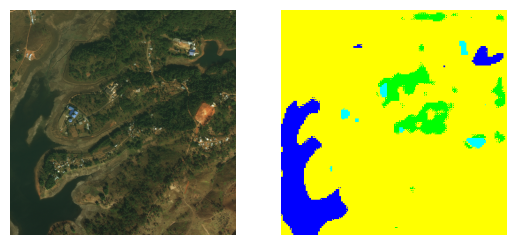

In [15]:
img = cv2.imread("/kaggle/input//test/100877_sat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.axis('off')

plt.show()

In [17]:
import torch

def test(model, test_dataloader, device):
    model.eval()
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to long integers if needed
            labels = labels.squeeze().long()

            predictions = model(inputs)

            # Convert predictions to label indices
            _, predicted_labels = torch.max(predictions, 1)

            # Ensure labels and predicted_labels are of the same type and shape
            correct = (predicted_labels == labels).sum().item()
            total_correct += correct
            total_pixels += labels.numel()

    if total_pixels == 0:
        print("No samples in the test set.")
        return

    test_accuracy = total_correct / total_pixels * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")

test(model, test_dataloader, device)

Test Accuracy: 71.71%
